# Train RNVP to solve inverse scattering problem

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring
from utils import ScatteringProblem
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes


In [2]:
# this parameters work when I/100
filename_out    = 'output/inn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 2e-3
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 200

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x     = 10
ndim_pad_x = 522

ndim_y     = 512
ndim_z     = 2
ndim_pad_zy = 18 


# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert (ndim_x + ndim_pad_x 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = True
train_max_likelihood = False


lambd_fit_forw         = 0.01 
lambd_mmd_forw         = 100
lambd_reconstruct      = 1.
lambd_mmd_back         = 500

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4


mmd_forw_kernels = [(0.2, 1/2), (1.5, 1/2), (3.0, 1/2)]
mmd_back_kernels = [(0.2, 1/2), (0.2, 1/2), (0.2, 1/2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 2
#
hidden_layer_sizes = 32
#
use_permutation = True
#
verbose_construction = False

In [3]:
lp = ScatteringProblem( device, batch_size, ndim_x, ndim_y, ndim_z, ndim_pad_x, ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, lambd_mmd_forw, lambd_mmd_back, lambd_reconstruct, mmd_back_weighted, y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
lp.read_data('/home/slaskina/simulations')
lp.normalize_inputs()

In [5]:
lp.update_hyperparameters( device, batch_size, ndim_x, ndim_y, ndim_z, ndim_pad_x, ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, lambd_mmd_forw, lambd_mmd_back, lambd_reconstruct, mmd_back_weighted, y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [6]:
lp.create_loaders()

In [7]:
def subnet(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes*2), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes*2,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))

input = Ff.InputNode(ndim_x + ndim_pad_x, name='input')


nodes = [input]
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)

In [8]:
lp.set_model(model)
lp.set_optimizer()

In [9]:
lp.train()

Epoch            L_fit       L_mmd_fwd      L_mmd_back       L_reconst     L_fit(test) L_mmd_fwd(test) L_mmd_back(test) L_reconst(test)
   000          7.2516          0.7483          1.2215          6.3520          0.5847          1.2214
   001          6.5701          0.5736          1.2212          6.5171          0.5793          1.2213
   002          6.1392          0.5712          1.2209          5.7781          0.5745          1.2208
   003          5.9260          0.5733          1.2207          5.9496          0.6015          1.2212
   004          5.5173          0.5700          1.2202          5.3808          0.5752          1.2202
   005          5.4927          0.5681          1.2199          5.5673          0.5696          1.2194
   006          5.2840          0.5641          1.2181          5.2326          0.5819          1.2185
   007          5.5915          0.5634          1.2174          5.4062          0.5668          1.2162
   008          5.1714          0.5625  

In [10]:
def create_table_from_outcomes(lp, pred, data_subset):
    sampled_inputs = lp.inputs[data_subset]
    df = pd.DataFrame(columns = ['true_shape', 'pred_shape', 'radius','pred_radius'], index = [])
    df['true_shape'] = sampled_inputs[:,:3].argmax(axis=1)
    df['pred_shape'] = pred[:,:3].argmax(axis=1)
    df['radius'] = np.take_along_axis(sampled_inputs[:,3:6],df.true_shape.values.reshape(-1,1), axis=1)
    df['pred_radius'] = np.take_along_axis(pred[:,3:6],df.pred_shape.values.reshape(-1,1), axis=1)
    df['radius_pd'] = sampled_inputs[:,6]
    df['pred_radius_pd'] = pred[:,6]
    df['length'] = sampled_inputs[:,7]
    df['pred_length'] = pred[:,7] # only those identified as cylinder should have lengh and pd_length  df.pred_shape.values ==2, pred[:,7], 0) 
    df['length_pd'] = sampled_inputs[:,8]
    df['pred_length_pd'] =  pred[:,8]
    df['volfraction'] = sampled_inputs[:,9]
    df['pred_volfraction'] = pred[:,9]
    return df

In [11]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

## let's look at the latent space

In [12]:
def predict_laten(lp, data_subset):
    x = lp.inputs_norm[data_subset].to(device)
    x = torch.cat((x, lp.add_pad_noise * torch.randn(1500, lp.ndim_pad_x).to(lp.device)), dim=1)
    out_y, _ = lp.model(x, jac  = True)
    return out_y[:,:2].cpu().detach()

In [13]:

bla= predict_laten(lp, lp.test_indices)

In [14]:
a = pd.DataFrame({'latent space': 0, 'value' : bla[:,0]})
b = pd.DataFrame({'latent space': 1, 'value' : bla[:,1]})
latent = pd.concat((a,b))

(array([[0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 1.50e+03, 0.00e+00, 0.00e+00],
        [1.00e+00, 0.00e+00, 6.00e+00, 4.00e+00, 1.90e+01, 5.00e+01,
         1.77e+02, 8.45e+02, 3.87e+02, 1.10e+01]]),
 array([-610.12878418, -532.04338837, -453.95799255, -375.87259674,
        -297.78720093, -219.70180511, -141.6164093 ,  -63.53101349,
          14.55438232,   92.63977814,  170.72517395]),
 <a list of 2 BarContainer objects>)

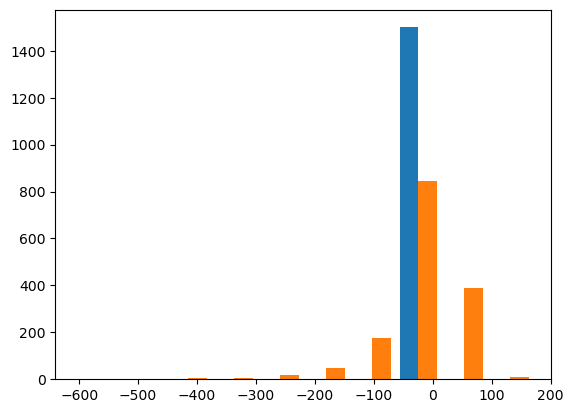

In [15]:
plt.hist(latent[latent['latent space'] ==0])

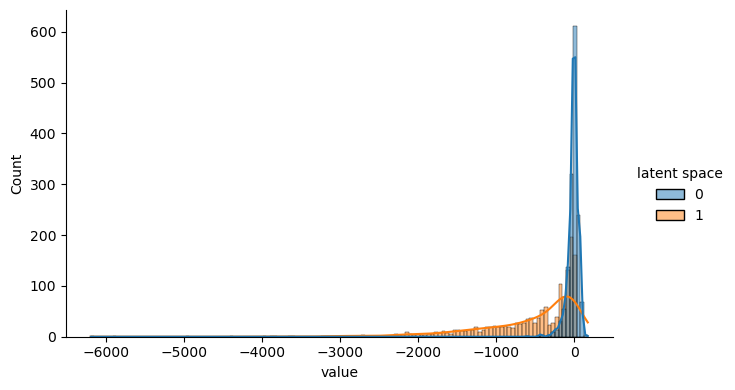

In [47]:
import seaborn as sns

sns.displot(data=latent, x='value', hue = 'latent space', kde=True, height = 4, aspect = 1.6)


Accuracy is 97.89%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.3669, hardsphere: 3910443.6376 and cylinder: 0.3690
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0004, hardsphere: 206.2369 and cylinder: 0.0006
MSE for cylinder length for correctly identified instances: 11.2200
MSE for cylinder length polydispersity for correctly identified instances: 0.0023
MSE for cylinder length for correctly identified instances: 8722.7433
        true_shape    feature     value
0         cylinder    sampled  2.524134
1         cylinder  predicted  2.368936
10        cylinder    sampled  9.017975
11        cylinder  predicted  6.622792
20        cylinder    sampled  8.275506
...            ...        ...       ...
102751    cylinder  predicted  3.857129
102760    cylinder    sampled  1.758735
102761    cylinder  predicted  1.831867
102770  hardsphere    sampled  5.401051
102771  hardsphere  predicted  5.477330

[

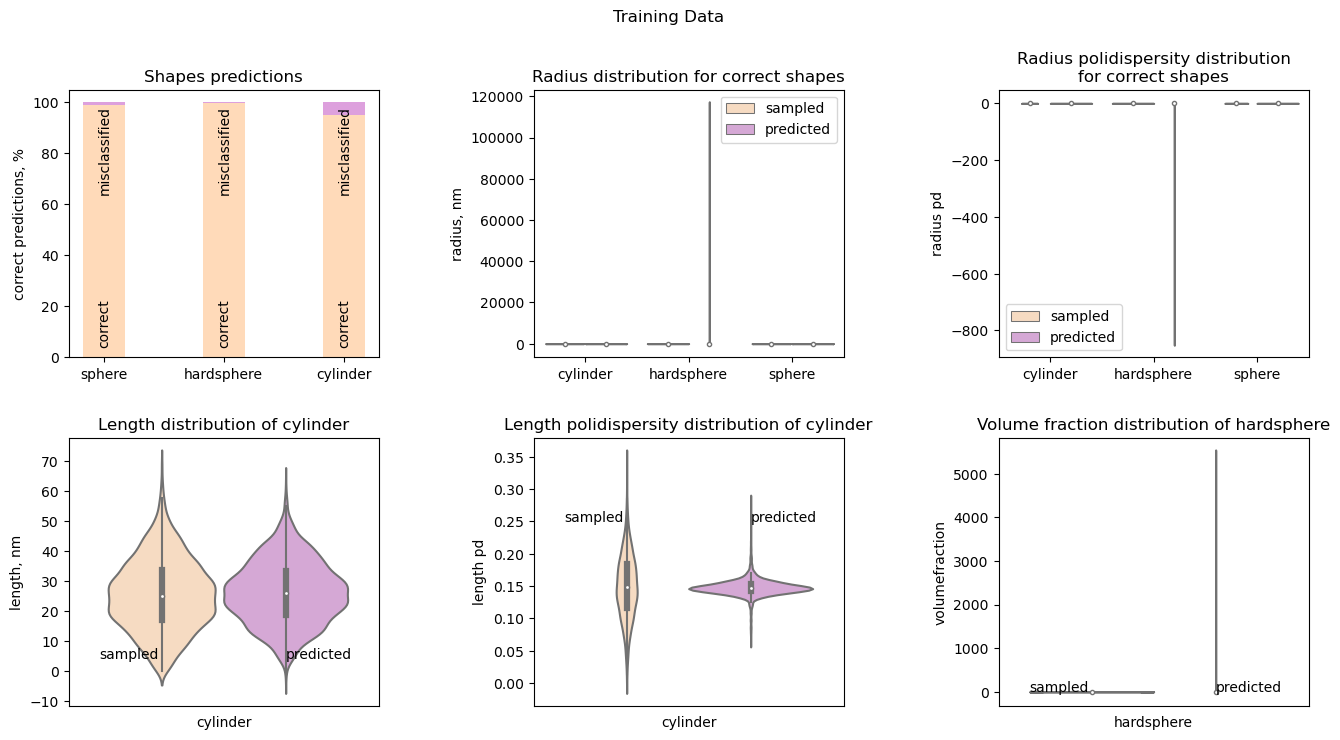

In [17]:
plot_outcomes_identified(df_train, 'Training')

In [18]:
df_train

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,2,2,2.524134,2.368936,0.101234,0.092199,25.025967,23.625976,0.088285,0.137386,0.00,0.001878
1,2,2,9.017975,6.622792,0.113885,0.110413,12.430745,17.039090,0.102884,0.142575,0.00,0.004425
2,2,2,8.275506,6.918648,0.093189,0.096113,6.854221,12.620242,0.129219,0.137211,0.00,-0.002263
3,2,2,5.314486,4.940874,0.066429,0.081876,17.509581,18.784161,0.177123,0.137938,0.00,0.000801
4,2,2,9.333292,9.756035,0.122863,0.087279,45.251961,46.561554,0.222478,0.165295,0.00,-0.004960
...,...,...,...,...,...,...,...,...,...,...,...,...
10495,1,1,7.130276,7.316761,0.096786,0.111655,0.000000,0.178290,0.000000,-0.001003,0.20,0.210081
10496,2,2,4.332434,4.054068,0.105447,0.122148,48.644299,45.018499,0.165738,0.161226,0.00,0.003348
10497,2,2,4.058639,3.857129,0.115531,0.111924,40.511623,37.826835,0.097219,0.147172,0.00,0.002232
10498,2,2,1.758735,1.831867,0.135644,0.092932,40.429825,36.523725,0.210499,0.142292,0.00,-0.000108


Accuracy is 97.70%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0984, hardsphere: 1.7918 and cylinder: 0.4013
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0004, hardsphere: 0.0007 and cylinder: 0.0006
MSE for cylinder length for correctly identified instances: 9.8762
MSE for cylinder length polydispersity for correctly identified instances: 0.0024
MSE for cylinder length for correctly identified instances: 0.0007
       true_shape    feature     value
0      hardsphere    sampled  1.576261
1      hardsphere  predicted  1.665855
10       cylinder    sampled  8.678663
11       cylinder  predicted  9.285870
20       cylinder    sampled  7.407975
...           ...        ...       ...
29281      sphere  predicted  3.560334
29290  hardsphere    sampled  4.958086
29291  hardsphere  predicted  5.221470
29300  hardsphere    sampled  7.116307
29301  hardsphere  predicted  7.226991

[5862 rows x 3 columns]


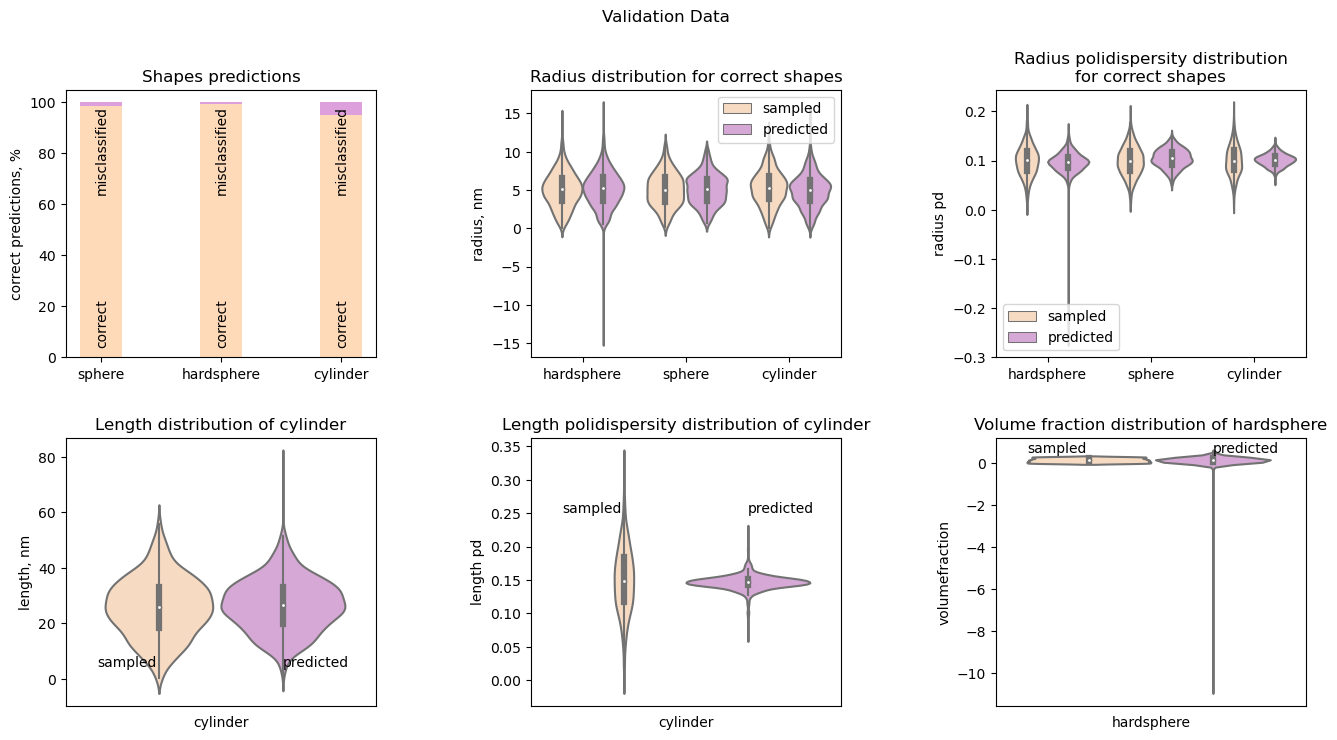

In [19]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 98.13%
[99.59016393442623, 99.0272373540856, 95.78313253012048]
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0574, hardsphere: 1.3425 and cylinder: 0.4103
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0004, hardsphere: 0.0005 and cylinder: 0.0006
MSE for cylinder length for correctly identified instances: 10.7930
MSE for cylinder length polydispersity for correctly identified instances: 0.0027
MSE for cylinder length for correctly identified instances: 0.0005


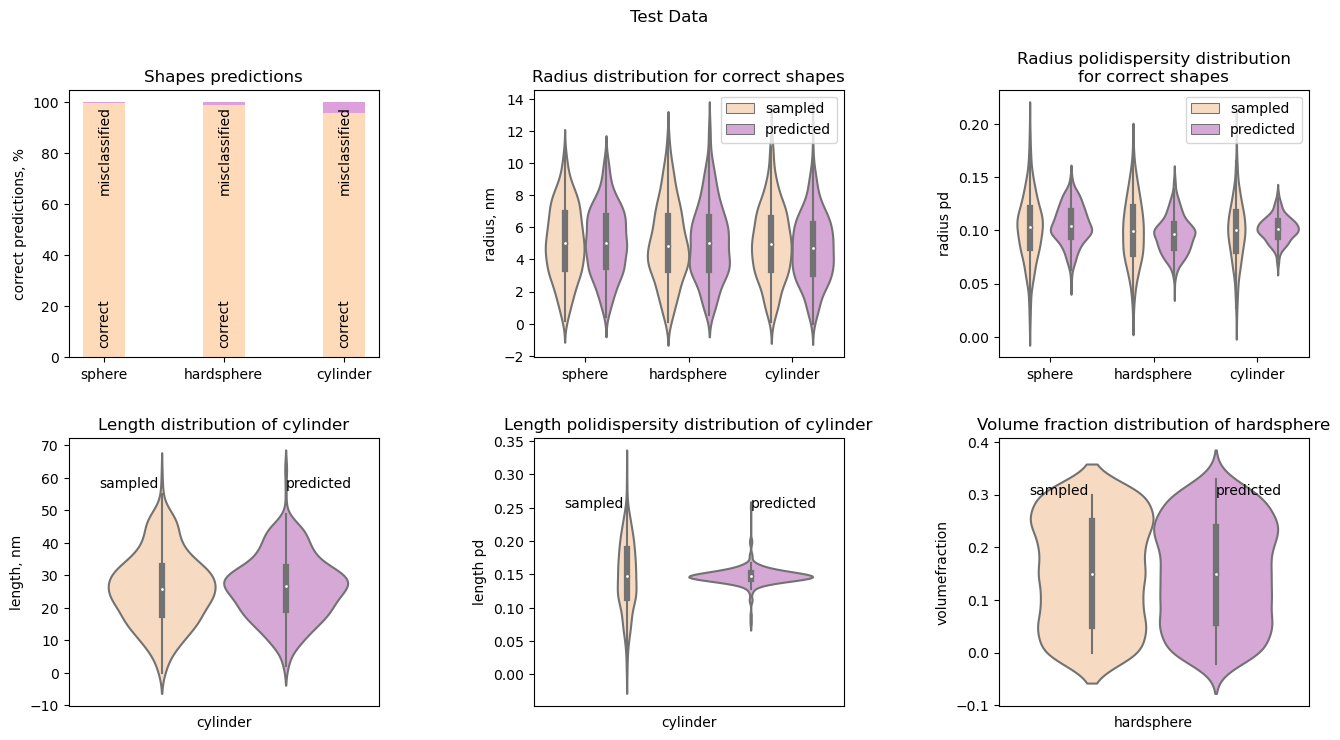

In [27]:
plot_outcomes_identified(df_test, 'Test')